In [1227]:
import yfinance
import pandas as pd
import requests
from io import StringIO
import copy
from tqdm.notebook import tqdm
from datetime import datetime
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error,classification_report,make_scorer,confusion_matrix, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from scipy.stats import poisson
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.linear_model import Lasso,ElasticNet,Ridge,BayesianRidge
import matplotlib.pyplot as plt
import os
import pickle
import copy
import seaborn as sns

import matplotlib.colors as colors
from sklearn.metrics import log_loss
from mpl_toolkits import mplot3d
teams_dict = {
    'Arsenal': ['Arsenal', 'ARS'],
    'Aston Villa': ['Aston Villa', 'AVL', 'AstonVilla', 'Villa'],
    'Barnsley': ['Barnsley', 'BAR'],
    'Birmingham City': ['Birmingham City', 'Birmingham', 'BIR'],
    'Blackburn Rovers': ['Blackburn Rovers', 'Blackburn', 'BLA'],
    'Blackpool': ['Blackpool', 'BLP'],
    'Bolton Wanderers': ['Bolton Wanderers', 'Bolton', 'BOL'],
    'Bournemouth': ['Bournemouth', 'BOU'],
    'Bradford City': ['Bradford City', 'Bradford', 'BFD'],
    'Brentford': ['Brentford', 'BRE'],
    'Brighton': ['Brighton & Hove Albion', 'Brighton', 'BHA', 'Brighton and Hove Albion'],
    'Burnley': ['Burnley', 'BUR'],
    'Cardiff City': ['Cardiff City', 'Cardiff', 'CAR'],
    'Charlton Athletic': ['Charlton Athletic', 'Charlton', 'CHA'],
    'Chelsea': ['Chelsea', 'CHE'],
    'Coventry City': ['Coventry City', 'Coventry', 'COV'],
    'Crystal Palace': ['Crystal Palace', 'CRY', 'CrystalPalace'],
    'Derby County': ['Derby County', 'Derby', 'DER'],
    'Everton': ['Everton', 'EVE'],
    'Fulham': ['Fulham', 'FUL'],
    'Huddersfield Town': ['Huddersfield Town', 'Huddersfield', 'HUD'],
    'Hull City': ['Hull City', 'Hull', 'HUL'],
    'Ipswich Town': ['Ipswich Town', 'Ipswich', 'IPS'],
    'Leeds United': ['Leeds United', 'Leeds', 'LEE'],
    'Leicester City': ['Leicester City', 'Leicester', 'LEI'],
    'Liverpool': ['Liverpool', 'LIV'],
    'Manchester City': ['Manchester City', 'Man City', 'MCI', 'ManCity'],
    'Manchester United': ['Manchester United', 'Man Utd', 'ManUnited', 'Man United', 'MUN'],
    'Middlesbrough': ['Middlesbrough', 'MID'],
    'Newcastle United': ['Newcastle United', 'Newcastle', 'NEW'],
    'Norwich City': ['Norwich City', 'Norwich', 'NOR', 'NorwichCity'],
    'Nottingham Forest': ['Nottingham Forest', 'Nottm Forest', 'NTF'],
    'Oldham Athletic': ['Oldham Athletic', 'Oldham', 'OLD'],
    'Portsmouth': ['Portsmouth', 'POR'],
    'Queens Park Rangers': ['Queens Park Rangers', 'QPR'],
    'Reading': ['Reading', 'RDG'],
    'Sheffield United': ['Sheffield United', 'Sheffield Utd', 'SU', 'SheffieldUnited'],
    'Sheffield Wednesday': ['Sheffield Wednesday', 'Sheffield Wed', 'SW', 'SheffieldWednesday'],
    'Southampton': ['Southampton', 'SOU'],
    'Stoke City': ['Stoke City', 'Stoke', 'STK'],
    'Sunderland': ['Sunderland', 'SUN'],
    'Swansea City': ['Swansea City', 'Swansea'],
    'Swindon Town': ['Swindon Town', 'SWI'],
    'Tottenham Hotspur': ['Tottenham Hotspur', 'Tottenham', 'TOT', 'Spurs'],
    'Watford': ['Watford', 'WAT'],
    'West Bromwich Albion': ['West Bromwich Albion', 'West Brom','WestBrom','WBA'],
    'West Ham United': ['West Ham United', 'West Ham', 'WHU', 'WestHam'],
    'Wigan Athletic': ['Wigan Athletic','WiganAthletic' ,'Wigan', 'WIG'],
    'Wimbledon': ['Wimbledon', 'WIM'],
    'Wolverhampton Wanderers': ['Wolverhampton Wanderers', 'Wolves', 'WOL']
}
def getTeam(number):
    return list(teams_dict.keys())[number]
def find_team_number(team_name_):
    for i, team_list in enumerate(teams_dict.values()):
        if team_name_.lower() in [x.lower() for x in team_list]:
            return i
    return -1 # Return -1 if no match is found
    

In [1228]:
with open('training_dict.pickle', 'rb') as handle:
    full_training_dict = pickle.load(handle)
    


In [1229]:
directory = "/Users/moksh/PL Predictions/Twitter/sentiments"
# Create an empty list to store the DataFrames
sentiments = {}

# Loop through each CSV file in the directory
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        # Read the CSV file into a DataFrame
        filepath = os.path.join(directory, filename)
        df = pd.read_csv(filepath)
        # Add the DataFrame to the list
        df.drop(['Unnamed: 0','Home Team','Away Team'],axis=1, inplace=True)
        df['sentiments2'] = df['sentiments'].apply(lambda x: x*-1)
        df.columns = ['Home','Away','h_sentiments','a_sentiments']
        sentiments[int(filename.split(".")[0])] = df



In [1230]:
combined_dict={}
for year in [2018,2019,2020,2021]:
    df1= copy.deepcopy(full_training_dict[year])
    df2= copy.deepcopy(sentiments[year])
    sentiments_list = []
    for i,row in df1.iterrows():
        sentiment_row = df2[(df2['Home']==row['Home'])&(df2['Away']==row['Away'])]
        if row['side'] == 0:
            sentiments_list.append(sentiment_row['h_sentiments'].values[0])
        elif row['side'] ==1:
            sentiments_list.append(sentiment_row['a_sentiments'].values[0])
    full_training_dict[year]['sentiments'] = sentiments_list
    

In [1231]:
training_df_teams =  pd.concat(list(full_training_dict.values())[:3],axis=0)
full_training_df = pd.concat(list(full_training_dict.values())[:3],axis=0).drop(['Home','Away'],axis=1)
test_df = full_training_dict[2021].drop(['Home','Away'],axis=1)
test_df_full = full_training_dict[2021]

In [1232]:
"""sc= StandardScaler()

X= full_training_df.drop('Goals_Scored_0',axis=1)
y= full_training_df['Goals_Scored_0']
X_train, __, y_train, _= train_test_split(X,y, test_size=0.00001)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

parameters = {'alpha_1': [1e-6, 1e-5, 1e-4], 'alpha_2': [1e-6, 1e-5, 1e-4], 
              'lambda_1': [1e-6, 1e-5, 1e-4], 'lambda_2': [1e-6, 1e-5, 1e-4]}
scorer = make_scorer(r2_score, greater_is_better=True)

# Create a Random Forest Regressor object
enet = BayesianRidge()

# Create a GridSearchCV object and fit to the data
grid_enet = GridSearchCV(enet, parameters, cv=5, scoring=scorer)
grid_enet.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters: ", grid_enet.best_params_)
print("Best Score: ", grid_enet.best_score_)"""

'sc= StandardScaler()\n\nX= full_training_df.drop(\'Goals_Scored_0\',axis=1)\ny= full_training_df[\'Goals_Scored_0\']\nX_train, __, y_train, _= train_test_split(X,y, test_size=0.00001)\n\nX_train = sc.fit_transform(X_train)\nX_test = sc.transform(X_test)\n\nparameters = {\'alpha_1\': [1e-6, 1e-5, 1e-4], \'alpha_2\': [1e-6, 1e-5, 1e-4], \n              \'lambda_1\': [1e-6, 1e-5, 1e-4], \'lambda_2\': [1e-6, 1e-5, 1e-4]}\nscorer = make_scorer(r2_score, greater_is_better=True)\n\n# Create a Random Forest Regressor object\nenet = BayesianRidge()\n\n# Create a GridSearchCV object and fit to the data\ngrid_enet = GridSearchCV(enet, parameters, cv=5, scoring=scorer)\ngrid_enet.fit(X_train, y_train)\n\n# Print the best parameters and score\nprint("Best Parameters: ", grid_enet.best_params_)\nprint("Best Score: ", grid_enet.best_score_)'

In [1233]:
total_r2= 0
total_mrse = 0
for i in tqdm(range(1)):
    X= full_training_df.drop('Goals_Scored_0',axis=1)
    y= full_training_df['Goals_Scored_0']
    X_train, __, y_train, _= train_test_split(X,y, test_size=0.00001)
    X_test = test_df.drop('Goals_Scored_0',axis=1)
    y_test = test_df['Goals_Scored_0']

    br = BayesianRidge()
    br.fit(X_train, y_train)
    preds = br.predict(X_test)
    total_r2+= (r2_score(y_test,preds))
    total_mrse+=(np.sqrt(mean_squared_error(y_test,preds)))

  0%|          | 0/1 [00:00<?, ?it/s]

In [1234]:
print(total_mrse)
print(total_r2)

1.1737923488204014
0.17920350903963123


In [1235]:
test_df_2 = copy.deepcopy(test_df)
test_df_2['elo_diff']= test_df_2['elo_diff'].apply(lambda x:np.abs(x))

In [1236]:
distributions = []
for score in preds:
    if score>0:
    
        lam = score
    else:
        lam = 0

    # Create a Poisson distribution object
    x = np.arange(0, 15)
    poisson_dist = poisson(lam)


    # Calculate the CDF and PDF of the Poisson distribution
    cdf = poisson_dist.cdf(x)
    pmf = poisson_dist.pmf(x)
    distributions.append([cdf,pmf])
    
    


In [1237]:
#Get game IDs from Elo Diffrences
test_df_2['game_id'] = test_df_2['elo_diff'].apply(lambda x:int(x*10**6))

In [1238]:
test_df_2

,elo_0,points_0,side,Average_xG_0,Average_xAG_0,Average_Scored_0,Average_Conceded_0,points_1,elo_1,Average_xAG_1,Average_Scored_1,Average_Conceded_1,Goals_Scored_0,elo_diff,sentiments,game_id
0,1671.978882,70.000000,0,1.200000,1.300000,2.000000,0.000000,19.000000,1866.674561,1.200000,0.000000,2.000000,2,194.695679,0.037445,194695678
1,1687.655029,19.000000,0,0.200000,0.700000,0.000000,3.000000,70.000000,1688.472168,1.300000,2.000000,0.000000,0,0.817139,-1.000000,817138
2,1747.712280,50.500000,0,1.250000,0.950000,2.000000,1.500000,61.000000,1690.281738,0.900000,1.000000,0.000000,1,57.430542,0.000000,57430541
3,1692.497437,51.666667,0,1.000000,0.833333,1.000000,0.333333,41.666667,1728.153442,1.166667,1.333333,1.000000,0,35.656006,0.000000,35656005
4,1733.510254,34.250000,0,1.900000,0.775000,0.500000,0.750000,45.000000,1684.243164,0.700000,0.750000,0.500000,0,49.267090,0.333333,49267089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,1698.075806,27.250000,1,1.300000,1.285714,1.142857,1.571429,40.500000,1832.433594,1.528571,1.571429,1.428571,0,134.357788,-0.459459,134357788
756,1693.308472,31.500000,1,1.000000,1.471429,1.000000,2.000000,39.500000,1814.583008,1.542857,1.142857,1.428571,3,121.274536,-0.000000,121274536
757,1860.791504,60.500000,1,1.685714,0.828571,1.285714,1.428571,34.500000,1715.028442,1.700000,1.000000,2.142857,0,145.763062,0.269231,145763061
758,1823.909790,40.000000,1,1.128571,1.228571,1.714286,1.285714,57.000000,1839.308838,1.428571,1.571429,1.285714,0,15.399048,-0.017241,15399047


In [1239]:
#0 as home win, 1 as draw, 2 as away win
game_pairs = []
for i,game in tqdm(enumerate(distributions)):
    game_id = test_df_2['game_id'][i]
    games = list(test_df_2[test_df_2['game_id']==game_id].index)
    game_pairs.append(games)
    print(getTeam(int(test_df_full['Home'][games[0]])), ' vs ',getTeam(int(test_df_full['Away'][games[0]])))

    
    
    """print(y_test[games[0]])
    # Create a range of values to plot the CDF and PDF for
    x = np.arange(0, 15)
    # Plot the CDF and PDF
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].step(x, distributions[games[0]][0])
    ax[0].set_title("Cumulative Distribution Function (CDF)")
    ax[1].bar(x, distributions[games[0]][1])
    ax[1].set_title("Probability Mass Function (PMF)")
    plt.show()"""
    
    
    """ 
    print(y_test[games[1]])
    x = np.arange(0, 15)
    # Plot the CDF and PDF
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].step(x, distributions[games[1]][0])
    ax[0].set_title("Cumulative Distribution Function (CDF)")
    ax[1].bar(x, distributions[games[1]][1])
    ax[1].set_title("Probability Mass Function (PMF)")
    plt.show() """
    
    print('\n')

    


    
    
    

0it [00:00, ?it/s]

Brentford  vs  Arsenal


Crystal Palace  vs  Brentford


Aston Villa  vs  Brentford


Brentford  vs  Brighton


Wolverhampton Wanderers  vs  Brentford


Brentford  vs  Liverpool


West Ham United  vs  Brentford


Brentford  vs  Chelsea


Brentford  vs  Leicester City


Burnley  vs  Brentford


Brentford  vs  Norwich City


Newcastle United  vs  Brentford


Brentford  vs  Everton


Tottenham Hotspur  vs  Brentford


Leeds United  vs  Brentford


Brentford  vs  Watford


Brighton  vs  Brentford


Brentford  vs  Manchester City


Brentford  vs  Aston Villa


Southampton  vs  Brentford


Liverpool  vs  Brentford


Brentford  vs  Manchester United


Brentford  vs  Wolverhampton Wanderers


Manchester City  vs  Brentford


Brentford  vs  Crystal Palace


Arsenal  vs  Brentford


Brentford  vs  Newcastle United


Norwich City  vs  Brentford


Brentford  vs  Burnley


Leicester City  vs  Brentford


Chelsea  vs  Brentford


Brentford  vs  West Ham United


Watford  vs  Brentford


Brentford  v

In [1240]:
# Define the colormap colors
new_colors =[(1.0, 1.0, 1.0), (1.0, 0.8, 0.0)]



# Create the colormap
cmap = colors.LinearSegmentedColormap.from_list("red_yellow", new_colors)

In [1241]:
probs = []
actual_outcomes = []
for i,game in tqdm(enumerate(distributions)):
    game_id = test_df_2['game_id'][i]
    games = list(test_df_2[test_df_2['game_id']==game_id].index)
    print(getTeam(int(test_df_full['Home'][games[0]])), ' vs ',getTeam(int(test_df_full['Away'][games[0]])))
    k=games[0]
    l=games[1]
    
    list1 = list(distributions[k][1])[:7]
    list2 = list(distributions[l][1][:7])
    n= len(list1)
    matrix = np.zeros((n+1, n+1))
    # Fill in the first column and first row with your lists
    matrix[1:, 0] = list1
    matrix[0, 1:] = list2

    # Fill in the rest of the array with the products of the first column and first row
    for i in range(1, n+1):
        for j in range(1, n+1):
            matrix[i, j] = matrix[i,0]*matrix[0,j]*100

    n_rows, n_cols = matrix.shape

    # Initialize the sums to zero
    diag_sum = 0
    right_sum = 0
    left_sum = 0

    # Sum the diagonal, right, and left values
    for i in range(n_rows):
        for j in range(n_cols):
            if i == j:
                diag_sum += matrix[i, j]/100
            elif j > i:
                right_sum += matrix[i, j]/100
            elif j < i:
                left_sum += matrix[i, j]/100



    matrix = np.round(matrix, decimals=1)






    labels = copy.deepcopy(matrix)
    labels = np.asarray(labels, dtype=str)
    for i in range(1, n+1):
        for j in range(1, n+1):
            labels[i, j] = labels[i, j]+"%"
            if labels[i, j]=='0.0%':
                labels[i, j]= '<1%'

    """#Print out the resulting array
    mask = np.zeros_like(matrix[1:,1:])
    mask[np.diag_indices_from(mask)] = True
    cmap = sns.cm.rocket_r
    sns.heatmap(matrix[1:,1:],cmap=cmap,linecolor='white',linewidths=1, annot=labels[1:,1:],fmt = '',
               annot_kws={"fontsize": 10, "fontweight": "normal", "color": "white"})
    plt.xlabel('Away')
    plt.ylabel('Home')
    plt.title("Score Distributions")
    plt.show()"""

    print('Home Win' ,left_sum)
    print('Draw', diag_sum)
    print('Away Win', right_sum)
    print('Final Score', y_test[k], ' - ', y_test[l])
    probs.append([left_sum,diag_sum,right_sum])
    if(y_test[k]>y_test[l]):
        actual_outcomes.append(0)
    elif y_test[k] < y_test[l]:
        actual_outcomes.append(2)
    else:
        actual_outcomes.append(1)
        
    print('\n')
    

0it [00:00, ?it/s]

Brentford  vs  Arsenal
Home Win 0.36144909270897146
Draw 0.26204977294083914
Away Win 0.39562338849087386
Final Score 2  -  0


Crystal Palace  vs  Brentford
Home Win 0.2825322651301443
Draw 0.2722515400402595
Away Win 0.46456683619226774
Final Score 0  -  0


Aston Villa  vs  Brentford
Home Win 0.482930855785181
Draw 0.2637922542984741
Away Win 0.27239448152872303
Final Score 1  -  1


Brentford  vs  Brighton
Home Win 0.39698580725038046
Draw 0.27593757869261665
Away Win 0.34655165667834864
Final Score 0  -  1


Wolverhampton Wanderers  vs  Brentford
Home Win 0.46575110233785166
Draw 0.27256136619587623
Away Win 0.28104377341372017
Final Score 0  -  2


Brentford  vs  Liverpool
Home Win 0.15693098609350234
Draw 0.20308407746969948
Away Win 0.6549348506161456
Final Score 3  -  3


West Ham United  vs  Brentford
Home Win 0.5585891496823907
Draw 0.23112750061936024
Away Win 0.22759268866034307
Final Score 1  -  2


Brentford  vs  Chelsea
Home Win 0.2124582419527842
Draw 0.226342056504413

In [1242]:
test_df_betting = test_df_full.iloc[:380][['Home','Away']]

In [1243]:
probs_new = copy.deepcopy(np.array(probs[:380]))

In [1244]:
test_df_betting['HW'] = [i[0] for i in probs_new ]
test_df_betting['D'] = [i[1] for i in probs_new ]
test_df_betting['AW'] = [i[2] for i in probs_new ]

In [1245]:
actual_outcomes_new= copy.deepcopy(np.array(actual_outcomes[:380]))

In [1246]:
test_df_betting['outcome'] =actual_outcomes_new

In [1247]:
log_losses= []
nums = []
for k in range(1,1000):
    over_outcomes=[]
    over_probs=[]
    for i,prob in enumerate(probs_new):
        if prob.max()>k/1000:
            over_probs.append(prob)
            over_outcomes.append(actual_outcomes_new[i])
    nums.append(len(over_outcomes))
    
    try:
        log_losses.append(log_loss(over_outcomes,over_probs,labels=[0,1,2]))
    except:
        log_losses.append(1)
nums = np.array(nums)
        

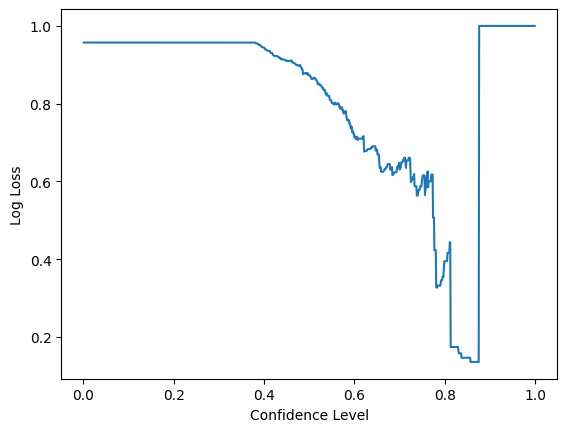

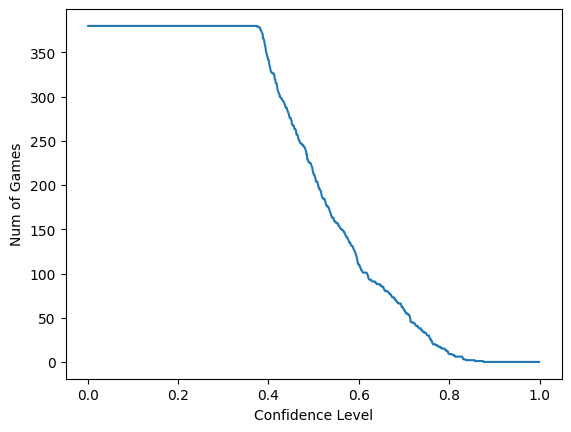

In [1248]:
plt.plot([i/1000 for i in range(1,1000)], log_losses)
plt.xlabel('Confidence Level')
plt.ylabel('Log Loss')
plt.show()
plt.plot([i/1000 for i in range(1,1000)], nums)
plt.xlabel('Confidence Level')
plt.ylabel('Num of Games')
plt.show()

In [1249]:
over_outcomes=[]
over_probs=[]
for i,prob in enumerate(probs_new):
    if prob.max()>0/100:
        over_probs.append(prob)
        over_outcomes.append(actual_outcomes_new[i])
confidence_preds =np.array(over_probs).argmax(axis=1)
confidence_true = np.array(over_outcomes)
print(classification_report(confidence_true,confidence_preds))
print(confusion_matrix(confidence_true,confidence_preds))

              precision    recall  f1-score   support

           0       0.58      0.76      0.66       163
           1       0.00      0.00      0.00        88
           2       0.54      0.70      0.61       129

    accuracy                           0.56       380
   macro avg       0.37      0.49      0.42       380
weighted avg       0.43      0.56      0.49       380

[[124   0  39]
 [ 49   0  39]
 [ 39   0  90]]


/Users/moksh/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/moksh/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/moksh/miniforge3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [1250]:
betting = pd.read_csv('/Users/moksh/PL Predictions/PremDataFull/Datasets/2021-2022.csv')

In [1251]:
betting=betting[['HomeTeam','AwayTeam','WHH','WHD','WHA']]

In [1252]:
betting['HomeTeam'] = betting['HomeTeam'].apply(find_team_number)

In [1253]:
betting['AwayTeam'] = betting['AwayTeam'].apply(find_team_number)

In [1254]:
betting.columns=['Home','Away','B365H','B365D','B365A']

In [1255]:
test_df_betting = test_df_betting.merge(betting,how='inner',on=['Home','Away'])

In [1256]:
#betting df functions
def predicted_outcome(HW,D,AW):
    return np.array([HW,D,AW]).argmax()
def predicted_outcome_percent(HW,D,AW):
    return max([HW,D,AW])
def strat_1(bet, outcome, H, D, A, predicted): 
    if outcome ==0 and predicted == 0:
        return H*bet 
    elif outcome ==1 and predicted == 1:
        return D * bet 
    elif outcome ==2 and predicted == 2:
        return A*bet 
    else:
        return -1*bet 

In [1257]:
test_df_betting['predicted_outcome'] = test_df_betting.apply(lambda x: predicted_outcome(x.HW,x.D,x.AW),axis=1)
test_df_betting['predicted_percent'] = test_df_betting.apply(lambda x: predicted_outcome_percent(x.HW,x.D,x.AW),axis=1)


In [1258]:
test_df_betting

,Home,Away,HW,D,AW,outcome,B365H,B365D,B365A,predicted_outcome,predicted_percent
0,9,0,0.361449,0.262050,0.395623,0,4.00,3.40,1.90,2,0.395623
1,16,9,0.282532,0.272252,0.464567,1,2.55,3.10,2.88,2,0.464567
2,1,9,0.482931,0.263792,0.272394,1,2.00,3.40,3.70,0,0.482931
3,9,10,0.396986,0.275938,0.346552,2,2.75,3.10,2.70,0,0.396986
4,49,9,0.465751,0.272561,0.281044,2,1.91,3.10,4.60,0,0.465751
...,...,...,...,...,...,...,...,...,...,...,...
375,0,38,0.556367,0.231273,0.229671,0,1.63,3.90,5.25,0,0.556367
376,46,38,0.531864,0.242916,0.243392,2,1.85,3.70,4.00,0,0.531864
377,38,0,0.240462,0.232851,0.544088,0,3.80,3.60,1.91,2,0.544088
378,0,46,0.441929,0.245736,0.330652,0,2.15,3.50,3.25,0,0.441929


In [1259]:
test_df_betting['HE'] = test_df_betting.apply(lambda x: x.HW*x.B365H, axis =1)
test_df_betting['DE'] = test_df_betting.apply(lambda x: x.D*x.B365D,axis =1)
test_df_betting['AE'] = test_df_betting.apply(lambda x: x.AW*x.B365A,axis = 1)

In [1260]:
test_df_betting

,Home,Away,HW,D,AW,outcome,B365H,B365D,B365A,predicted_outcome,predicted_percent,HE,DE,AE
0,9,0,0.361449,0.262050,0.395623,0,4.00,3.40,1.90,2,0.395623,1.445796,0.890969,0.751684
1,16,9,0.282532,0.272252,0.464567,1,2.55,3.10,2.88,2,0.464567,0.720457,0.843980,1.337952
2,1,9,0.482931,0.263792,0.272394,1,2.00,3.40,3.70,0,0.482931,0.965862,0.896894,1.007860
3,9,10,0.396986,0.275938,0.346552,2,2.75,3.10,2.70,0,0.396986,1.091711,0.855406,0.935689
4,49,9,0.465751,0.272561,0.281044,2,1.91,3.10,4.60,0,0.465751,0.889585,0.844940,1.292801
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
375,0,38,0.556367,0.231273,0.229671,0,1.63,3.90,5.25,0,0.556367,0.906878,0.901965,1.205772
376,46,38,0.531864,0.242916,0.243392,2,1.85,3.70,4.00,0,0.531864,0.983948,0.898787,0.973568
377,38,0,0.240462,0.232851,0.544088,0,3.80,3.60,1.91,2,0.544088,0.913755,0.838262,1.039209
378,0,46,0.441929,0.245736,0.330652,0,2.15,3.50,3.25,0,0.441929,0.950148,0.860078,1.074621


In [1261]:
def test_betting(starting_amount,bet_percent, testing_df, threshold=0):
    df = copy.deepcopy(testing_df)
    df = df[df['predicted_percent']>threshold]
    payouts = []
    totals=[]
    total = starting_amount
    bet_amount =total*bet_percent
    for i,x in df.iterrows():
        total += bet_amount*-1

        if bet_amount<total:
            payout = strat_1(bet_amount, x.outcome,x.B365H,x.B365D,x.B365A, x.predicted_outcome)
            payouts.append(payout)

            if payout>0:
                total+= payout
            totals.append(total)
        else:
            return -1
    df['payouts'] = payouts
    df['total_payouts'] = totals
    
    return df




In [1272]:
final_betting= test_betting(1000,0.05,test_df_betting, 0)

In [1263]:
snp = yfinance.download("VTI", start = "2021-08-13", end = "2022-05-22")

[*********************100%***********************]  1 of 1 completed


In [1264]:
snp['Initial'] = [1000 for i in range(len(snp))]

In [1281]:
snp['Close'] = snp['Close'].apply(lambda x: x*4.344992511491331
)

Text(0.5, 1.0, 'Vanguard Total Stock Market Index Fund ETF')

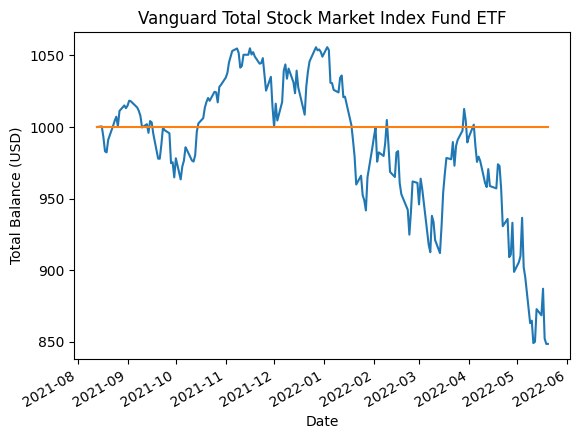

In [1284]:

snp['Close'].plot()
snp['Initial'].plot()
plt.xlabel('Date')
plt.ylabel('Total Balance (USD)')
plt.title("Vanguard Total Stock Market Index Fund ETF")

In [1285]:
snp['Close'][-1]

848.6639691681623

In [1274]:
sum(list(final_betting['total_payouts']))/len(list(final_betting['total_payouts']))

1064.996052631579

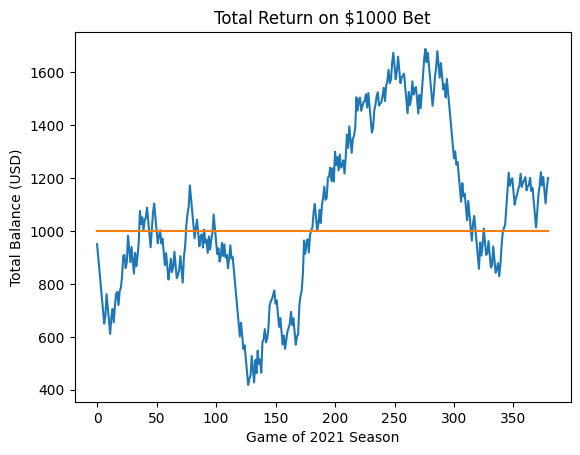

In [1286]:
plt.plot(final_betting['total_payouts'])
plt.xlabel('Game of 2021 Season')
plt.ylabel('Total Balance (USD)')
plt.title('Total Return on $1000 Bet')
plt.plot([1000 for i in range(len(final_betting_full))])

In [1268]:
payouts= []
for i in range(100):
    try:
        final_betting = test_betting(1000,0.05,test_df_betting,i/100)
        payouts.append(final_betting.iloc[-1]['total_payouts'])
    except:
        payouts.append(0)
        
        


Text(0, 0.5, 'Amount on $1000 Bet')

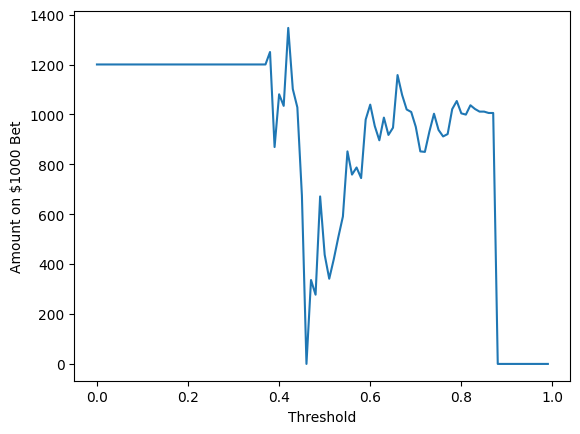

In [1269]:
plt.plot([i/100 for i in range(100)],payouts)
plt.xlabel('Threshold')
plt.ylabel('Amount on $1000 Bet')